In [28]:
import pandas as pd 
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import os 
import numpy as np
# !pip install pyreadr
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadr
from lifelines.plotting import add_at_risk_counts
from scipy.stats import linregress


In [29]:
# Model path 
base_directory = "/mnt/ncshare/ozkilim/BRCA/results/platinum_responce_results_5e4/HGSOC_TRAIN_TCGA_15_PorpoiseMMF_concat_60_ViT_primary_s1"

In [30]:
def get_model_preds(base_directory):
    """Given a trained model folder generte a df with patients probs and labels."""
    df = pd.read_csv("/mnt/ncshare/ozkilim/BRCA/HGSOC_platinum_responce/HGSOC_TCGA_main.csv")
    # remove proteins columns...
    columns_to_drop = [col for col in df.columns if (col.isupper() or "orf" in col)]
    # Drop these columns from the DataFrame.
    main_df = df.drop(columns=columns_to_drop)
    ensemble_data = []
    # Loop through the files in the base directory
    for i in range(5):
        file_path = os.path.join(base_directory, f'split_{i}_results.pkl')
        df = pd.read_pickle(file_path)
        # Extract data
        for key, value in df.items():
            slide_id = str(value['slide_id'])  # Convert slide_id to string
            prob = value['prob'][0][1]        # Assuming this is already a scalar
            label = str(value['label'])       # Convert label to string
            ensemble_data.append({'slide_id': slide_id, 'prob': prob, 'label': label})

    # Creating DataFrame from the collected data
    ensemble_df = pd.DataFrame(ensemble_data)
    # Convert 'slide_id' and 'label' to string if they are not already
    ensemble_df['slide_id'] = ensemble_df['slide_id'].astype(str)
    ensemble_df['label'] = ensemble_df['label'].astype(str)
    # Compute the mean probability for each slide_id and label
    ensemble_df['slide_id'] = ensemble_df['slide_id'].astype(str)
    ensemble_df['label'] = ensemble_df['label'].astype(str)
    # Compute the mean probability for each slide_id and label
    mean_probs_df = ensemble_df.groupby(['slide_id', 'label'], as_index=False).mean()

    merged_df = main_df.merge(mean_probs_df[['slide_id','prob']], on='slide_id', how='left')

    merged_df['slide_type'] = merged_df['slide_id'].str.extract(r'-([^-\.]+)\.')
    # print(len(merged_df)) # 348 slides...

    merged_df = merged_df.groupby('case_id').agg({'prob': 'mean','label': 'first','Tumor Substage':'first','Tumor Grade': 'first', 'Patient Age': 'first', 'Proteomic subtype': 'first' }).reset_index()

    merged_df = merged_df.dropna(subset=['prob'])

    return merged_df

### Merging all relevant tables

In [31]:
# Data Loading
tcgasurv = pd.read_excel("/mnt/ncshare/ozkilim/BRCA/data/survival_scripts/TCGA-CDR-SupplementalTableS1.xlsx", sheet_name="TCGA-CDR")
tcgasurv2 = pd.read_excel("/mnt/ncshare/ozkilim/BRCA/data/survival_scripts/TCGA-CDR-SupplementalTableS1.xlsx", sheet_name="ExtraEndpoints")
tcgasurv = pd.merge(tcgasurv, tcgasurv2, on="bcr_patient_barcode")
# Data Manipulation
tcgasurv['stage_categories'] = np.where(tcgasurv['ajcc_pathologic_tumor_stage'].isin(["Stage I", "Stage IA", "Stage IB"]), "Stage I",
                                np.where(tcgasurv['ajcc_pathologic_tumor_stage'].isin(["Stage II", "Stage IIA", "Stage IIB"]), "Stage II",
                                np.where(tcgasurv['ajcc_pathologic_tumor_stage'].isin(["Stage III", "Stage IIIA", "Stage IIIB", "Stage IIIC"]), "Stage III",
                                np.where(tcgasurv['ajcc_pathologic_tumor_stage'] == "Stage IV", "Stage IV", np.nan))))

for column in ['OS.time', 'DSS.time', 'DFI.time', 'PFI.time', 'PFS.time']:
    tcgasurv[column] = tcgasurv[column] / 30.5

allclinical = pyreadr.read_r("/mnt/ncshare/ozkilim/BRCA/data/survival_scripts/allclinical_TCGA.RData")
allclinical = allclinical['allclinical']

allclinical = pd.merge(allclinical, tcgasurv, left_on="submitter_id", right_on="bcr_patient_barcode")
allclinical['age_at_diagnosis_years'] = allclinical['age_at_diagnosis'] / 365.25
allclinical['age_cat70'] = np.where(allclinical['age_at_diagnosis_years'] >= 70, ">=70", "<70")
# More Data Loading and Merging
panTCGA_drug_treatment = pd.read_csv("/mnt/ncshare/ozkilim/BRCA/data/TCGA_metadata/panTCGA_drug_treatment.txt", sep='\t')

drugs = pd.read_csv("/mnt/ncshare/ozkilim/BRCA/data/survival_scripts/hnsc_lusc_luad_ov_breast_drugs.txt", sep='\t')
plat_patients = panTCGA_drug_treatment[panTCGA_drug_treatment['pharmaceutical_therapy_drug_name'].str.lower().isin(drugs[drugs['platina'] == 1]['Drug'].str.lower())]['bcr_patient_barcode'].unique()

# here load the model...
wsi = get_model_preds(base_directory)

brca = pd.read_csv('/mnt/ncshare/ozkilim/BRCA/data/survival_scripts/10780432ccr210981-sup-262479_2_supp_7287946_qwylwd.txt', sep='\t')
merged = pd.merge(brca, allclinical, left_on='PatientID', right_on='submitter_id')
merged['case_id'] = merged['PatientID']
print(len(wsi))
merged = pd.merge(merged, wsi, on='case_id')

126


/home/ozkilim/anaconda3/envs/clam/lib/python3.7/site-packages/ipykernel_launcher.py:27: DtypeWarning: Columns (5283,7094) have mixed types.Specify dtype option on import or set low_memory=False.


In [32]:
merged.columns.to_list()
merged["Tumor Substage"].value_counts() # very few...
merged["stage_categories"].value_counts()
len(merged["PatientID"].unique())

98

In [33]:
# merged = pd.read_csv("/mnt/ncshare/ozkilim/BRCA/data/survival_scripts/merged.tmp.txt", sep="\t")
# print(len(merged["PatientID"].unique()))

# merged.dropna(subset=["prob"], inplace=True)  # Remove rows with NaN values in the specified column

# print(merged["prob"].isnull().values.any())
# print(merged["label"].isnull().values.any())
# print(merged["HRDscore_normalized"].isnull().values.any())


In [34]:
merged['HRDscore'] = merged["LST"] + merged["Telomeric.AI"] + merged["HRD-LOH"]

merged["BRCA status"] = np.where(merged["BRCA-status_simplified"] == 'intact', 1, 0)
merged['HRDscore_normalized'] = merged['HRDscore'] / 100.0
y_true = merged['label']
# Initialize variables to keep track of the best AUC and coefficients
best_auc = 0
best_coeffs = (0, 0)

for coeff_prob in np.arange(0, 1.01, 0.01):
    for coeff_hrd in np.arange(0, 1.01, 0.01):
        # Ensure the sum of coefficients is 1
        if coeff_prob + coeff_hrd == 1:
            # Calculate the ensemble score with current coefficients
            merged['ensemble'] = (coeff_prob * merged['prob'] + coeff_hrd * merged['HRDscore_normalized'])
            
            # Calculate AUC for the current ensemble

            current_auc = roc_auc_score(y_true, merged['ensemble'])
            
            # Update the best AUC and coefficients if the current AUC is better
            if current_auc > best_auc:
                best_auc = current_auc
                best_coeffs = (coeff_prob, coeff_hrd)

print(f"Best AUC: {best_auc}")
print(f"Best Coefficients: prob={best_coeffs[0]}, HRDscore_normalized={best_coeffs[1]}")
merged['ensemble'] = (merged['prob'] + merged['HRDscore_normalized']) / 2
merged['ensemble_optimal'] = (best_coeffs[0] * merged['prob'] + best_coeffs[1] * merged['HRDscore_normalized'])

Best AUC: 0.8421052631578947
Best Coefficients: prob=0.27, HRDscore_normalized=0.73


0.17712331


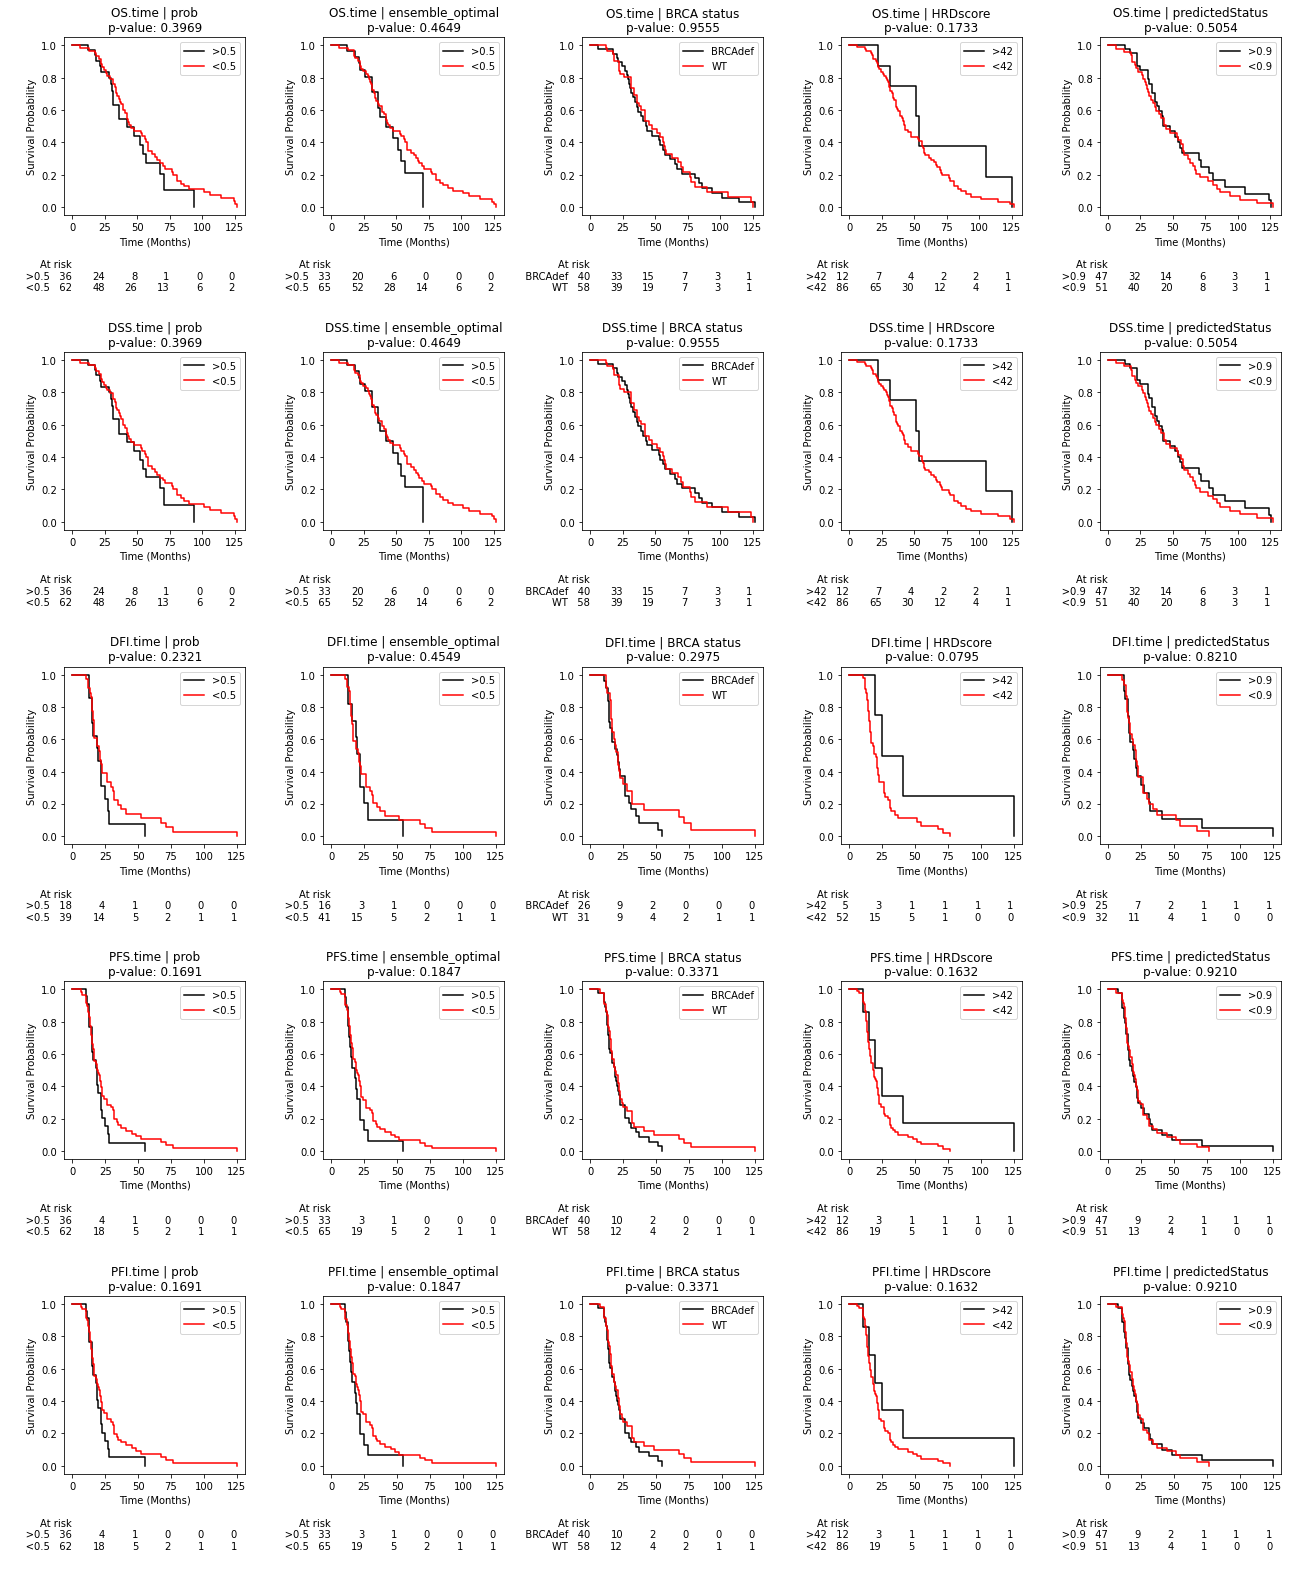

In [42]:

fpr, tpr, thresholds = roc_curve(merged['label'], merged['prob'])
# Calculate the Youden's J statistic
youden = tpr - fpr
# Find the optimal threshold
optimal_threshold_index = youden.argmax()
optimal_threshold = thresholds[optimal_threshold_index]
print(optimal_threshold)

times = ['OS.time','DSS.time','DFI.time','PFS.time','PFI.time']
thresholds = [optimal_threshold,0.5,0.5,42,0.9]
groupings = ['prob','ensemble_optimal','BRCA status','HRDscore','predictedStatus']
labels = [[">0.5","<0.5"],[">0.5","<0.5"],["BRCAdef","WT"],[">42","<42"],[">0.9","<0.9"]]

plt.figure(figsize=(18, 22))  # Adjusting the figure size for a 5x5 grid

# Flatten the grid loop since we're just iterating through each combination
for i, time in enumerate(times):
    for j, grouping in enumerate(groupings):
        ax = plt.subplot(5, 5, i * 5 + j + 1)
        
        # Apply the threshold uniformly for demonstration
        threshold = thresholds[j]  # This assumes a 1:1 mapping for simplicity

        merged_no_nans = merged.dropna(subset=[time])

        group1 = merged_no_nans[merged_no_nans[grouping] < threshold]
        group2 = merged_no_nans[merged_no_nans[grouping] >= threshold]

        kmf1 = KaplanMeierFitter()
        kmf2 = KaplanMeierFitter()

        # Check for sufficient data

        kmf1.fit(durations=group1[time], event_observed=group1['label'], label=labels[j][0])
        kmf2.fit(durations=group2[time], event_observed=group2['label'], label=labels[j][1])

        # Plotting
        kmf1.plot_survival_function(ci_show=False, ax=ax,color='black')
        kmf2.plot_survival_function(ci_show=False, ax=ax,color='red')
        add_at_risk_counts(kmf1, kmf2,rows_to_show=['At risk'],xticks=[0,25,50,75,100,125])

        # Log-rank test and displaying p-value
        results = logrank_test(group1[time], group2[time], event_observed_A=group1['label'], event_observed_B=group2['label'])
        ax.set_title(f'{time} | {grouping}\np-value: {results.p_value:.4f}')
        ax.set_xlabel('Time (Months)')
        ax.set_ylabel('Survival Probability')

plt.tight_layout()
plt.savefig('../figures/survival_analysis.png', dpi=300, facecolor='white')  # or 'roc_curve.svg' for vector format

plt.show()

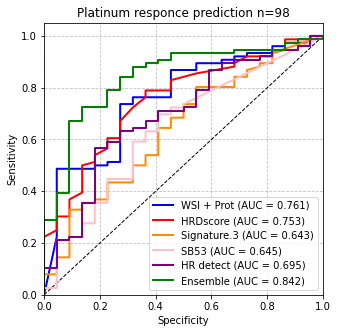

In [36]:
# ROC analysis curves 

# Your existing code to calculate AUC and plot ROC for individual scores
y_true = merged['label']
y_scores = merged['prob']

# Compute ROC curve and AUC for 'prob'
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve for 'prob'
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'WSI + Prot (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')


# Compute and plot ROC curve and AUC for 'HRDscore'
fpr_hrd, tpr_hrd, thresholds_hrd = roc_curve(y_true, merged['HRDscore'])
roc_auc_hrd = auc(fpr_hrd, tpr_hrd)
plt.plot(fpr_hrd, tpr_hrd, color='red', lw=2, label=f'HRDscore (AUC = {roc_auc_hrd:.3f})')


fpr_hrd, tpr_hrd, thresholds_hrd = roc_curve(y_true, merged['Signature.3'])
roc_auc_hrd = auc(fpr_hrd, tpr_hrd)
plt.plot(fpr_hrd, tpr_hrd, color='darkorange', lw=2, label=f'Signature.3 (AUC = {roc_auc_hrd:.3f})',alpha=1)

fpr_hrd, tpr_hrd, thresholds_hrd = roc_curve(y_true, merged['SBS3'])
roc_auc_hrd = auc(fpr_hrd, tpr_hrd)
plt.plot(fpr_hrd, tpr_hrd, color='pink', lw=2, label=f'SB53 (AUC = {roc_auc_hrd:.3f})',alpha=1)

fpr_hrd, tpr_hrd, thresholds_hrd = roc_curve(y_true, merged['predictedStatus'])
roc_auc_hrd = auc(fpr_hrd, tpr_hrd)
plt.plot(fpr_hrd, tpr_hrd, color='purple', lw=2, label=f'HR detect (AUC = {roc_auc_hrd:.3f})',alpha=1)

# Assuming best_coeffs contains the optimal coefficients
# Update 'ensemble' score with the optimal coefficients
# Compute ROC curve and AUC for the optimal ensemble
fpr_ensemble_optimal, tpr_ensemble_optimal, thresholds_ensemble_optimal = roc_curve(y_true, merged['ensemble_optimal'])
roc_auc_ensemble_optimal = auc(fpr_ensemble_optimal, tpr_ensemble_optimal)

# Plot the ROC curve for the optimal ensemble
plt.plot(fpr_ensemble_optimal, tpr_ensemble_optimal, color='green', lw=2, label=f'Ensemble (AUC = {roc_auc_ensemble_optimal:.3f})')

plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('Platinum responce prediction n='+str(len(merged)))
plt.legend(loc="lower right")
plt.savefig('../figures/HDR_auc.png', dpi=300, facecolor='white')  # or 'roc_curve.svg' for vector format

plt.show()

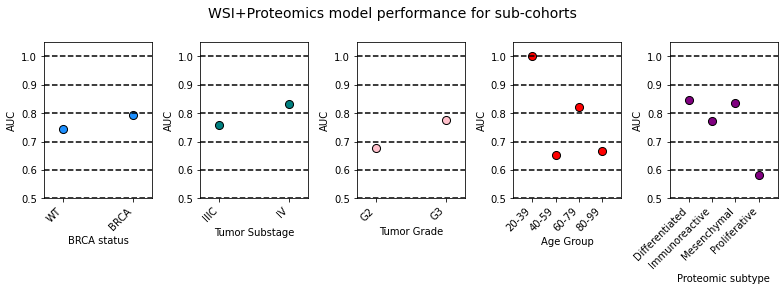

In [37]:
# make some plot with ACC vs groupings.... for each model ...

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd

def calculate_and_plot_auc(df, grouping_column, subplot_index, n_rows, n_cols):
    # Bin ages if the grouping is by 'Patient Age'
    if grouping_column == 'Patient Age':
        bins = range(0, 120, 20)
        labels = [f'{i}-{i + 19}' for i in bins[:-1]]
        df['Age Group'] = pd.cut(df[grouping_column], bins=bins, labels=labels, right=False)
        grouping_column = 'Age Group'  # Use the binned age for grouping
    
    results = []
    for name, group in df.groupby(grouping_column):
        if group['label'].nunique() > 1:  # Ensure at least two different labels
            fpr, tpr, thresholds = roc_curve(group['label'], group["prob"])
            roc_auc = auc(fpr, tpr)
            patient_count = group.shape[0]
            results.append((name, roc_auc, patient_count))
        else:
            results.append((name, float('nan'), group.shape[0]))  # Handle groups with insufficient variation
    
    results_df = pd.DataFrame(results, columns=[grouping_column, 'AUC', 'Patient Count'])
    results_df = results_df.dropna(subset=[grouping_column])

    # Plotting as a dot plot
    plt.subplot(n_rows, n_cols, subplot_index)
    # Create an x-axis index for each unique group after filtering
    x_ticks = range(len(results_df[grouping_column]))




    if grouping_column == 'BRCA status':
        color = "dodgerblue"
        plt.xticks([0,1], ["WT","BRCA"], rotation=45, ha='right')
    else:
        plt.xticks(x_ticks, results_df[grouping_column], rotation=45, ha='right')

    if grouping_column == 'Tumor Substage':
        color = "teal"
    if grouping_column == 'Tumor Grade':
        color = "pink"
    if grouping_column == 'Age Group':
        color = "red"
    if grouping_column == 'Proteomic subtype':
        color = "purple"

    plt.scatter(x_ticks, results_df['AUC'], color=color, edgecolor='black', s=65)


    current_xlim = plt.xlim()
    # Calculate new limits to add some padding. Adjust the factor to control the space
    padding = (current_xlim[1] - current_xlim[0]) * 0.2  # Adjusts the padding, 10% of the current range
    new_xlim = (current_xlim[0] - padding, current_xlim[1] + padding)
    # Set new x-axis limits
    plt.xlim(new_xlim)

    plt.xlabel(grouping_column)
    plt.axhline(y=0.5, color='k', linestyle='--')
    plt.axhline(y=0.6, color='k', linestyle='--')
    plt.axhline(y=0.7, color='k', linestyle='--')
    plt.axhline(y=0.8, color='k', linestyle='--')
    plt.axhline(y=0.9, color='k', linestyle='--')
    plt.axhline(y=1, color='k', linestyle='--')

    plt.ylabel('AUC')
    plt.ylim(0.5, 1.05)  # Adjust as necessary
    # plt.title(f'AUC by {grouping_column}')

# Assuming 'df' is your DataFrame
# Define the groupings you're interested in
groupings = ['BRCA status','Tumor Substage','Tumor Grade', 'Patient Age', 'Proteomic subtype']  # Add more groupings as needed

# Plot settings
n_rows = 1  # Adjust based on the number of groupings
n_cols = len(groupings)
plt.figure(figsize=(n_cols * 2.2, n_rows * 4))

# Calculate AUC and plot for each grouping
for i, grouping in enumerate(groupings, start=1):
    calculate_and_plot_auc(merged, grouping, i, n_rows, n_cols)

# make colors same as in data presentation table... 
plt.suptitle("WSI+Proteomics model performance for sub-cohorts",y=1,fontsize=14)
plt.tight_layout()
plt.savefig('../figures/clincal_analysis.png', dpi=300, facecolor='white')  # or 'roc_curve.svg' for vector format
plt.show()

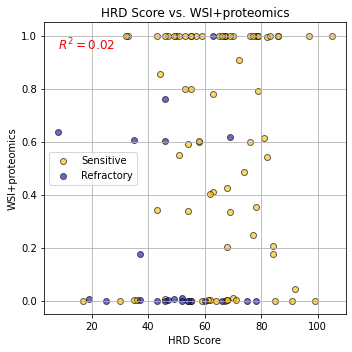

In [38]:

# Assuming 'merged' is your DataFrame with 'HRDscore' and 'prob' columns
# Calculate R-squared score
slope, intercept, r_value, p_value, std_err = linregress(merged["HRDscore"], merged["prob"])
r_squared = r_value**2

# Create the scatter plot
plt.figure(figsize=(5, 5))  # Make the figure square

merged_sensitive = merged[merged["label"]==1]
plt.scatter(merged_sensitive["HRDscore"], merged_sensitive["prob"], c="#FFBD00", edgecolor='black', alpha=0.6,label="Sensitive")
merged_refractory = merged[merged["label"]==0]
plt.scatter(merged_refractory["HRDscore"], merged_refractory["prob"], c="#090C9B", edgecolor='black', alpha=0.6, label="Refractory")

# Add labels and a title
plt.xlabel('HRD Score')
plt.ylabel('WSI+proteomics')
plt.title('HRD Score vs. WSI+proteomics')

# Add the R-squared value to the plot
plt.text(np.min(merged["HRDscore"]), np.max(merged["prob"]), f'$R^2 = {r_squared:.2f}$', fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')

# Optionally, add a trendline
# x = np.linspace(np.min(merged["HRDscore"]), np.max(merged["HRDscore"]), 100)
# y = slope * x + intercept
# plt.plot(x, y, color='red', linestyle='--', linewidth=1)

plt.grid(True)  # Add grid
# plt.axis('square')  # Force square aspect ratio
plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.legend()
plt.savefig('../figures/HRD_corrolation.png', dpi=300, facecolor='white')  # or 'roc_curve.svg' for vector format
plt.show()